In [1]:
# compare the data/mc for cluster shape/position, variables used for BDT training
# to make sure the bdt is not just learning about the difference between data/mc

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = 2018
category = 0
version = '/v4/v4/'

data_path = '/mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data2018/'+version+'/normalized/'
sig_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v5/normalized/'
lumi = (5.632467289 +2.572903489 +1.685313225 +3.988453305 +3.068943620 +3.527270568 +8.609721915) * 1000
print("lumi is "+str(round(lumi/1000,2))+" fb-1")
fpath_bkg['mc_mx12'] = sig_path+"signal_125_12_10m_1pb_weighted.root"
fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root"
    

lumi is 29.09 fb-1


In [3]:
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)

mc_mx12 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v5/normalized/signal_125_12_10m_1pb_weighted.root
[0.02332728 0.69241756 0.6954052  0.6994117  0.70647645]
(128953,)
data /mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data2018//v4/v4//normalized/Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root
[29085.074]
(8634529,)


# load BDT

In [4]:
import pandas as pd
import pickle

bdt_model = 2
if bdt_model == 0:
    model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1.pickle', "rb" ))
elif bdt_model == 1:
    model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs.pickle', "rb" ))
else:
    model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2.pickle', "rb" ))


In [7]:
%%time

start_t = time.time()
jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
npv = {}
npu = {}
nJets = {}
nJets_50gev = {}
jetPt = {}
jetPhi = {}
jetEta = {}
metPhi = {}
met = {}
jetMet_dPhiMin4 = {}

cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterZSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaPhiSpread = {}

cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitClusterNStation = {}

bdt_score = {}

keys = ['mc_signal', 'mc_bkg', 'data']
keys = ['mc_mx55_signal', 'mc_mx55_bkg','mc_mx12_signal', 'mc_mx12_bkg', 'data']
keys = ['mc_mx12_bkg', 'data']


for k in keys:
    if k[:2] == 'mc':
        T = tree_bkg[k[:7]]
    else:
        T = tree_bkg['data']
        

    sel_cluster = T.array('cscRechitClusterTime') < -12.5
    print("cluster selection efficiency:", np.count_nonzero(sel_cluster.flatten())/len(sel_cluster.flatten()))
    
#     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterNRechitChamberPlus11') == 0)
#     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterNRechitChamberPlus12') == 0)
#     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterNRechitChamberMinus11') == 0)
#     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterNRechitChamberMinus12') == 0)
#     sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitClusterEta')) < 2.1)

# ########### BRANCHES ############
    sel_ev = sel_cluster.sum() ==1 

    cscRechitClusterXSpread[k] = T.array('cscRechitClusterXSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterYSpread[k] = T.array('cscRechitClusterYSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterZSpread[k] = T.array('cscRechitClusterZSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterEtaSpread[k] = T.array('cscRechitClusterEtaSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterPhiSpread[k] = T.array('cscRechitClusterPhiSpread')[sel_cluster][sel_ev][:,0]

    cscRechitClusterX[k] = T.array('cscRechitClusterX')[sel_cluster][sel_ev][:,0]
    cscRechitClusterY[k] = T.array('cscRechitClusterY')[sel_cluster][sel_ev][:,0]
    cscRechitClusterZ[k] = T.array('cscRechitClusterZ')[sel_cluster][sel_ev][:,0]
    cscRechitClusterEta[k] = T.array('cscRechitClusterEta')[sel_cluster][sel_ev][:,0]
    cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_cluster][sel_ev][:,0]

    cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitClusterEtaPhiSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterNStation[k] = T.array('cscRechitClusterNStation')[sel_cluster][sel_ev][:,0]

   ##### cluster-level variables ##### 
    if bdt_model == 0:
        
        bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
         'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
         'cscRechitClusterNStation':cscRechitClusterNStation[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterX':cscRechitClusterX[k],
         'cscRechitClusterY':cscRechitClusterY[k],
         'cscRechitClusterZ':cscRechitClusterZ[k],
        }
    elif bdt_model == 1:
        bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
         'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
         'cscRechitClusterNStation':cscRechitClusterNStation[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterX':np.abs(cscRechitClusterX[k]),
         'cscRechitClusterY':np.abs(cscRechitClusterY[k]),
         'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
        }
    else:
        bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
         'cscRechitClusterEtaSpread': cscRechitClusterEtaSpread[k],
         'cscRechitClusterPhiSpread':cscRechitClusterPhiSpread[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterPhi':cscRechitClusterPhi[k],
         'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
         'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
        }


    
    
    

##### bdt variables ####
 
    
    dataset = pd.DataFrame(bdt_var)
    bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
    print(len(bdt_score[k]) == np.count_nonzero(sel_ev))

    met[k] = T.array('met') [sel_ev]
    metPhi[k] = T.array('metPhi')[sel_ev]
    npv[k] = T.array('npv')[sel_ev]
    weight[k] = T.array('weight')[sel_ev]*lumi
    pileupWeight[k] = T.array('pileupWeight')[sel_ev]
    if k == 'data':
        pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
        weight[k] = weight[k] * 0.0 + 1.0
    

cluster selection efficiency: 0.12141961616356448
True
cluster selection efficiency: 0.12141961616356448
True
cluster selection efficiency: 0.2470005682875927
True
CPU times: user 20.6 s, sys: 4.87 s, total: 25.5 s
Wall time: 41.9 s


# shape comparison

In [164]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

# Plotting ncsc
start_t = time.time()

logy = 0

rt.gStyle.SetOptFit(1011)
# var = [cscSegClusterX, cscSegClusterY, cscSegClusterZ, cscSegClusterXSpread, cscSegClusterYSpread, cscSegClusterZSpread, cscSegClusterEtaPhiSpread, cscSegClusterNStation]
# title = ['cluster X [cm]', 'cluster Y [cm]', 'cluster Z [cm]', 'cluster X spread [cm]', 'cluster Y spread [cm]', 'cluster Z spread [cm]', 'cluster #eta-#phi spread', 'N_{station}']
# bins = [[25,0,700],[25,0,700],[25,500,1100],[25,0,90], [25,0,90], [25,0,300], [25,0,0.1], [5,0,5]]
# names = ['cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterNStation']

var = [cscSegClusterX, cscSegClusterY, cscSegClusterZ, cscSegClusterNStation]
title = ['cluster X [cm]', 'cluster Y [cm]', 'cluster Z [cm]', 'N_{station}']
bins = [[25,0,700],[25,0,700],[25,500,1100],[5,0,5]]
names = ['cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterNStation']



key_plot = ['mc_mx55_bkg','data']

for j,v in enumerate(var):
    if not j == 3:continue
    print(j)
    leg = rt.TLegend(0.55,0.80,0.87,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    h = {}
    for i,k in enumerate(keys):
        h[k] = create_TH1D( np.abs(v[k]), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = pileupWeight[k]* weight[k])
#         h[k] = create_TH1D( cscSegClusterYSpread[k], axis_title=['cluster Y spread [cm]', 'Events'], name=k, binning=[25,0,90], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterZSpread[k], axis_title=['cluster Z spread [cm]', 'Events'], name=k, binning=[25,0,300], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterEtaPhiSpread[k], axis_title=['cluster #eta-#phi spread', 'Events'], name=k, binning=[25,0,0.1], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterNStation[k], axis_title=['N_{station}', 'Events'], name=k, binning=[5,0,5], weights = pileupWeight[k]* weight[k])
        h[k].SetLineColor(std_color_list[i])
        if 'bkg' in k: h[k].SetLineColor(std_color_list[i-1])
        if 'data' in k: h[k].SetLineColor(std_color_list[i-3])
        leg.AddEntry(h[k],k)
        if logy: h[k].SetMaximum(h[k].GetMaximum()*10)
        else: h[k].SetMaximum(h[k].GetMaximum()*1.5)
    #     h[str(i)].SetMinimum(0.1)
        if 'signal' in k: h[k].SetLineStyle(2)
        h[k].GetXaxis().SetLabelSize(0.04)
        h[k].DrawNormalized('same hist')
        h[k].Scale(1./h[k].Integral())
#     c = make_ratio_plot([h['mc_mx55_bkg'],h['data']], fit = False, logy=False, in_tags = ["MC","Data"], ratio_bounds = [0,3])

    c.SetRightMargin(0.05)
    if logy: c.SetLogy()
#     leg.Draw()

    c.Draw()
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_eta2p1_ME1112veto/"+names[j]+".png")
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot/"+names[j]+".png")

# print(time.time()-start_t)

NameError: name 'cscSegClusterX' is not defined

# with ratio plot

bdt efficiency data 0.07519282511210762
data 195125
bdt efficiency mc_mx12_bkg 0.15052888527257932
mc_mx12_bkg 1229
data 195125
mc_mx12_bkg 1229
data 195125
mc_mx12_bkg 1229
data 195125
mc_mx12_bkg 1229
data 195125
mc_mx12_bkg 1229
data 195125
mc_mx12_bkg 1229
data 195125
mc_mx12_bkg 1229
data 195125
mc_mx12_bkg 1229


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


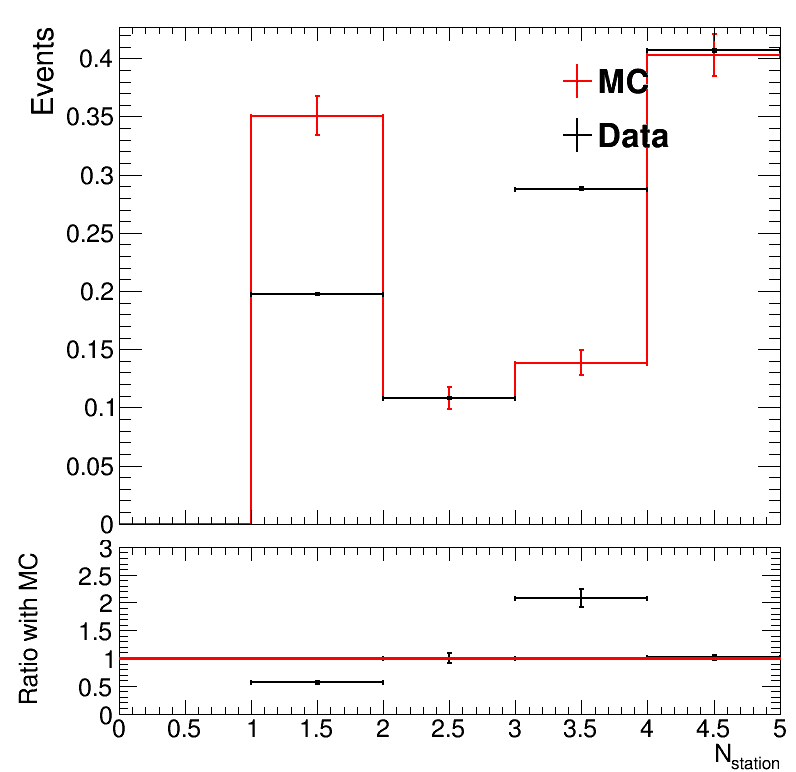

In [9]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

# Plotting ncsc
start_t = time.time()

logy = 0

rt.gStyle.SetOptFit(1011)
if bdt_model <=1 :
    var = [bdt_score, cscRechitClusterX, cscRechitClusterY, cscRechitClusterZ, cscRechitClusterXSpread, cscRechitClusterYSpread, cscRechitClusterZSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterNStation]
    title = ['BDT score', 'cluster X [cm]', 'cluster Y [cm]', 'cluster Z [cm]', 'cluster X spread [cm]', 'cluster Y spread [cm]', 'cluster Z spread [cm]', 'cluster #eta-#phi spread', 'N_{station}']
    bins = [[20,0,1], [25,0,700],[25,0,700],[25,500,1100],[25,0,90], [25,0,90], [25,0,300], [25,0,0.1], [5,0,5]]
    names = ['bdt_score', 'cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterNStation']
else:

    var = [bdt_score, cscRechitClusterEta, cscRechitClusterPhi, cscRechitClusterZ, cscRechitClusterEtaSpread, cscRechitClusterPhiSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterNStation]
    title = ['BDT score', 'cluster #eta', 'cluster #phi', 'cluster Z [cm]', 'cluster #eta spread', 'cluster #phi spread', 'cluster #eta-#phi spread', 'N_{station}']
    bins = [[20,0,1], [25,1,2.5],[25,-3.2,3.2],[25,500,1100], [25,0,0.2], [25,0,0.2],[25,0,0.1], [5,0,5],]
    names = ['bdt_score', 'cscRechitClusterEta', 'cscRechitClusterPhi', 'cscRechitClusterZ',  'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterEtaPhiSpread','cscRechitClusterNStation']

key_plot = ['data', 'mc_mx55_bkg']
key_plot = ['data', 'mc_mx12_bkg']

# key_plot = ['data', 'mc_mx12_signal']

# key_plot = ['data', 'mc_ctau10_bkg']

# key_plot = ['data', 'mc_all_bkg']

if bdt_model == 1:
    bdt_cut = 0.9227871
else:
    bdt_cut = 0.7802247 #wp90
for j,v in enumerate(var):
#     if not j == 0:continue
    leg = rt.TLegend(0.55,0.80,0.87,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    h = {}
    for i,k in enumerate(key_plot):
        h[k] = create_TH1D( v[k], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = pileupWeight[k]* weight[k])
        h[k].SetLineColor(std_color_list[i])
        if logy: h[k].SetMaximum(h[k].GetMaximum()*10)
        else: h[k].SetMaximum(h[k].GetMaximum()*10)
    #     h[str(i)].SetMinimum(0.1)
        if 'signal' in k: h[k].SetLineStyle(2)
        h[k].GetXaxis().SetLabelSize(0.04)
#         h[k].DrawNormalized('same hist')
        if names[j] == 'bdt_score': print('bdt efficiency', k, np.count_nonzero(v[k]>bdt_cut)/len(v[k]))
        print(k, len(v[k]))
        h[k].Scale(1./h[k].Integral())
    c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]]], fit = False, logy=False, in_tags = ["MC","Data"], ratio_bounds = [0,3], draw_opt = ['hist E1','E1'])

    c.SetRightMargin(0.05)
    if logy: c.SetLogy()

    c.Draw()
    c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_etaphi/mc_mx12_bkg_"+names[j]+"_withRatio.png")

